# 02_Using a Polynomial Model
I'll work on the previously created model where we see the need to model a curvature we see obvious in the data

**Key Assumptions**  
__________
- Linear relationship (Linear Regression is quite sensitive to outliers)
- Multivariate normality (check for residuals distribution, should be close to normal)
- No or little multicollinearity (VIF > 10)
- No auto-correlation (e.g.  y(x+1) is not independent from the value of y(x) in some specific cases
- Homoscedasticity (residuals are equal across the regression line)

In [1]:
# Import key liberaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm  # color map 

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [2]:
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Use Boston Housing dataset from Scikit-Learn
#[Link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)
#create a dataframe with provided components

b_data = load_boston()
data = pd.DataFrame(data = b_data.data, columns= b_data.feature_names)
data['PRICE'] = b_data.target

# I'll pick a few features to simplify my example
data = data[['CRIM','INDUS','RM','DIS','PRICE']]

In [4]:
data.head(3)

,CRIM,INDUS,RM,DIS,PRICE
0,0.00632,2.31,6.575,4.0900,24.0
1,0.02731,7.07,6.421,4.9671,21.6
2,0.02729,7.07,7.185,4.9671,34.7


In [5]:
# Data Split
X = data.drop('PRICE', axis=1)
y = data['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [6]:
# Prepare X_train & X_test for polinomial Regression
poly_features = PolynomialFeatures(degree=2)
X_train = pd.DataFrame(poly_features.fit_transform(X_train), columns = poly_features.get_feature_names())
X_test  = pd.DataFrame(poly_features.transform(X_test)     , columns = poly_features.get_feature_names())

In [7]:
# Model Training
regr = LinearRegression()
regr.fit(X_train, y_train)

print('Training data r-squared:', round(regr.score(X_train, y_train), 4))
print('Test data r-squared:', round(regr.score(X_test, y_test), 4))

# Print coeffecients
param_list = ['const'] + list(X_train.columns)
coef_list = [regr.intercept_]+list(regr.coef_)
pd.DataFrame({'coef': coef_list}, index = param_list)

Training data r-squared: 0.6706
Test data r-squared: 0.7703


,coef
const,62.171630
1,0.000000
x0,-4.533181
x1,-0.541258
x2,-15.241024
x3,-5.598024
x0^2,0.005140
x0 x1,0.295194
x0 x2,-0.160185
x0 x3,-0.250559


## Testing for Multicolinearity

after adding 2-way interactions and quadratic terms, you'd expect a significant rise to Multicollinearity. Not sure yet how to handle it and what impact it might have on the model knowing we've had a significan't improvement in R-Squared (& adjusted) and the model's ability to perform on test_data is better

In [8]:
# Pearson correlation coefficients(Assumption is we're using continuous data)
def get_corr(data):
    mask = np.zeros_like(data.corr())
    triangle_indices = np.triu_indices_from(mask)
    mask[triangle_indices]= True
#     plt.figure(figsize= (6,5))
    sns.heatmap(data.corr(), mask = mask, annot=True, annot_kws={"size":13})
    sns.set_style('whitegrid')
    plt.title('Pearson correlation coefficients')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
#     plt.show()

    
# Calculate the Variance Infilation Factor for all parameters
def get_vif(X_incl_constant):
    vif = []
    for i in range(1, X_incl_constant.shape[1]):
        vif.append(variance_inflation_factor(exog=X_incl_constant.values, exog_idx=i))
    vif_data = pd.DataFrame({'coef_name': X_incl_constant.columns[1:X_incl_constant.shape[1]], 'VIF': np.around(vif, 2)})
    
    plt.bar(vif_data['coef_name'], height = vif_data['VIF'] )
    plt.hlines(10, -0.5, X_incl_constant.shape[1]-1.5,  linestyles='--', colors='red', label='VIF threshold' )
    plt.title('Variance Infilation Factor plot')
    plt.ylabel('VIF')
    plt.legend()
    for i, v in enumerate(vif_data['VIF']):
        plt.text(i-0.1  , v + 0.5  , str(v), color='black', fontweight='bold')
#     plt.show()

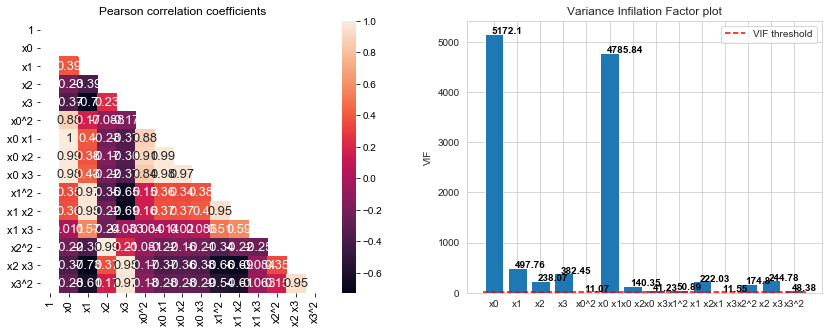

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(121)
get_corr(X_train)
plt.subplot(122)
get_vif(X_train)

### Thoughts about Multicollinearity in this case

The need to reduce multicollinearity depends on its severity and your primary goal for your regression model. Keep the following three points in mind:

1. The severity of the problems increases with the degree of the multicollinearity. Therefore, if you have only moderate multicollinearity, you may not need to resolve it.
2. Multicollinearity affects only the specific independent variables that are correlated. Therefore, if multicollinearity is not present for the independent variables that you are particularly interested in, you may not need to resolve it. Suppose your model contains the experimental variables of interest and some control variables. If high multicollinearity exists for the control variables but not the experimental variables, then you can interpret the experimental variables without problems.
3. Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity.

Over the years, I’ve found that many people are incredulous over the third point, so here’s a reference!

*The fact that some or all predictor variables are correlated among themselves does not, in general, inhibit our ability to obtain a good fit nor does it tend to affect inferences about mean responses or predictions of new observations.*  —Applied Linear Statistical Models, p289, 4th Edition.

[Source](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)

## Residuals analysis

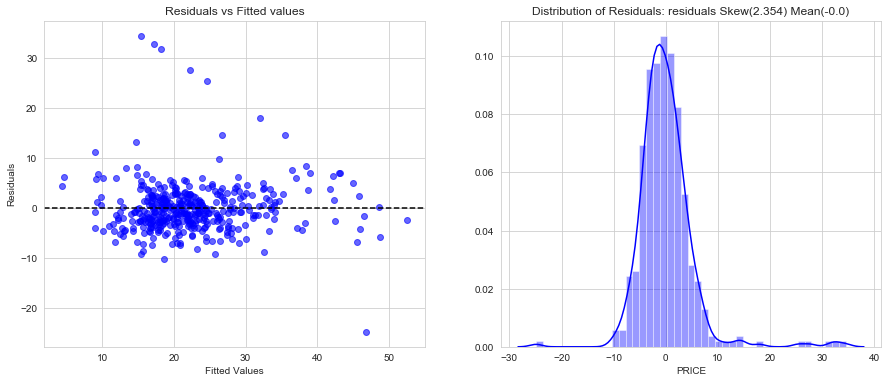

In [10]:
# Residuals
fitted_values = regr.predict(X_train)
residuals = y_train - regr.predict(X_train)
# residuals vs predicted values
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(x= fitted_values, y= residuals, c='blue', alpha=0.6)
plt.axhline(0, 0, 1, color='black',ls = '--')
plt.xlabel('Fitted Values', fontsize=None)
plt.ylabel('Residuals', fontsize=None)
plt.title('Residuals vs Fitted values')

plt.subplot(122)
# Distribution of Residuals (log prices) - checking for normality
resid_mean = round(residuals.mean(), 3)
resid_skew= round(residuals.skew(), 3)
sns.distplot(residuals, color='blue')
plt.title(f'Distribution of Residuals: residuals Skew({resid_skew}) Mean({resid_mean})')
plt.show()

## Results Summary
- Adj. R-squared: good measure to adjust for R2 increases due to added features
- Baisian Information Criterion (BIC): to show the model complexity - compare the BIC between mutiple models and use the lower value

In [11]:
# Using StatsModels
# Evaluating Model Performance
def sm_summary(X,y):
    # add a constant column if not present
    if X.iloc[:, 0].mean()!=1:
        X = sm.add_constant(X)
        
    model=sm.OLS(y, X.values)
    results= model.fit()
    print(results.summary())

In [12]:
sm_summary(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     56.57
Date:                Fri, 10 Apr 2020   Prob (F-statistic):           1.21e-84
Time:                        14:34:04   Log-Likelihood:                -1246.4
No. Observations:                 404   AIC:                             2523.
Df Residuals:                     389   BIC:                             2583.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.1716     24.237      2.565      0.0

### Learnings:

- Model performance improved by considering polynomial features
- Interestingly, BIC numbers improved indicating we didn't add much complexity
- Residuals look more random about the line (except for a few outliers)

**on the other side**  
- The number of Features increased dramatically
- Multicolliniarity is soaring

next question: can we reduce the number of features, fix multicollinearity and improve model performance?